In [120]:
import sys
sys.path.append("../")

In [121]:
from utils.common_train_utils import *
from utils.draw_candle_image import *
from utils.evaluate_old_models import *
from functools import partial
from model_code import *
from ta import add_all_ta_features
from ta.utils import dropna
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import ta
import ta.momentum
import ta.trend
import tempfile
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import inspect

In [122]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [123]:
print(logdir)

C:\Users\ADMIN\AppData\Local\Temp\tmpe15xzdgg\tensorboard_logs


In [124]:
dataset_folder = "../dataset/eth_with_ema_macd_trend"

In [125]:
config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]

In [126]:
dataset_test = load_dataset_of_each_type_and_combine(f"{dataset_folder}/test", candle_type_and_directory_save)
total_data_test = len(dataset_test)

In [127]:
dataset_train = load_dataset_of_each_type_and_combine(f"{dataset_folder}/train", candle_type_and_directory_save)
total_data_train = len(dataset_train)

In [128]:
dataset_train

<_ConcatenateDataset element_spec=(TensorSpec(shape=(6, 1), dtype=tf.float64, name=None), TensorSpec(shape=(6, 1), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int32, name=None), TensorSpec(shape=(287, 287, 3), dtype=tf.float64, name=None), TensorSpec(shape=(6, 4), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [129]:
def model_5_biLSTM_with_ema_macd_trend(image_shape, days_result, days_of_ema_9=2, days_of_macd_history=2):
    trend_type_input = keras.layers.Input(shape=(1,), name="trend_type_input")
    x1 = keras.layers.Dense(8, activation='relu')(trend_type_input)
    
    image_input = keras.layers.Input(shape=image_shape, name="image_input")
    x2 = keras.layers.Conv2D(8, (2, 2), activation='relu')(image_input)
    x2 = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x2)
    x2 = keras.layers.Flatten()(x2)
    x2 = keras.layers.Dense(64, activation='relu')(x2)
    x2 = keras.layers.Dropout(0.1)(x2)
    
    ema_9_input = keras.layers.Input(shape=(days_of_ema_9,), name="ema_9_input")
    x3 = keras.layers.Dense(8, activation='relu')(ema_9_input)
    
    macd_history_input = keras.layers.Input(shape=(days_of_macd_history,), name="macd_history_input")
    x4 = keras.layers.Dense(8, activation='relu')(macd_history_input)
    
    combined = keras.layers.concatenate([x3, x4, x1, x2])
    
    z = keras.layers.Dense(128, activation='relu')(combined)
    z = keras.layers.Dropout(0.1)(z)
    z = keras.layers.Dense(128, activation='relu')(z)
    
    input_lstm = keras.layers.RepeatVector(days_result)(z)
    lstm = keras.layers.Bidirectional(keras.layers.LSTM(256, activation="tanh", return_sequences=True))(input_lstm)
    lstm = keras.layers.Dropout(0.1)(lstm)
    lstm = keras.layers.Bidirectional(keras.layers.LSTM(256, activation="tanh", return_sequences=True))(lstm)
    lstm = keras.layers.Dropout(0.1)(lstm)
    output_lstm = keras.layers.TimeDistributed(keras.layers.Dense(2))(lstm)
    
    model = keras.models.Model(inputs=[ema_9_input, macd_history_input, trend_type_input, image_input], outputs=output_lstm)
    
    return model, "model_5_biLSTM_ema_macd_trend"


In [130]:
function_transform_origin = get_open_close_prices_percent_of_last_days_result_for_ema_macd_trend_dataset
model_function = model_5_biLSTM_with_ema_macd_trend
function_evaluate_old_model = evaluate_fpt_model_5_biLSTM_with_trend_type_2023_2024
image_shape = get_image_shape(dataset_train, index_of_image=3)
model, model_name = model_function(image_shape, days_result)

In [131]:
batch_size = int(input("batch_size = 2^x, x = ").strip())
STEPS_PER_EPOCH = total_data_train // batch_size + 1
name_sub_folder_save_metrics = f"{model_name}_{os.path.basename(dataset_folder)}"
name_folder_save_metrics = f"sizes/{model_name}_{os.path.basename(dataset_folder)}"
max_epochs = int(input(f"max_epochs = "))
metric_mae_name = "mae"
metric_mae_object = keras.metrics.MeanAbsoluteError(name=metric_mae_name)
metric_mse_name = "mse"
metric_mse_object = keras.metrics.MeanSquaredError(name=metric_mse_name)
val_loss_metric_mae_to_stop = float(input("val_loss_metric_mae_to_stop = "))
val_loss_metric_mse_to_stop = float(input("val_loss_metric_mse_to_stop = "))
start_learning_rate = float(input("start_learning_rate = ").strip())
shuffle_buffer = 300
print(f"{STEPS_PER_EPOCH=}")
number_epochs_to_decrease_lr = int(input("number_epochs_to_decrease_lr = "))
number_epochs_to_wait = int(input("number_epochs_to_wait = "))

STEPS_PER_EPOCH=178


In [132]:
print(f"{STEPS_PER_EPOCH=}")
print(f"{val_loss_metric_mae_to_stop=}")
print(f"{val_loss_metric_mse_to_stop=}")
print(f"{number_epochs_to_decrease_lr=}")
print(f"{number_epochs_to_wait=}")

STEPS_PER_EPOCH=178
val_loss_metric_mae_to_stop=-1.0
val_loss_metric_mse_to_stop=-1.0
number_epochs_to_decrease_lr=10
number_epochs_to_wait=10


In [133]:
model_name

'model_5_biLSTM_ema_macd_trend'

In [134]:
(total_data_train, total_data_test)

(1597, 252)

In [135]:
dataset_train_1 = dataset_train.shuffle(shuffle_buffer)
dataset_test_1 = dataset_test.shuffle(shuffle_buffer)

dataset_train_2 = dataset_train_1.batch(batch_size)
dataset_test_2 = dataset_test_1.batch(batch_size)

transform_function = partial(function_transform_origin, days_result)
dataset_train_3 = dataset_train_2.map(transform_function)
dataset_test_3 = dataset_test_2.map(transform_function)

In [136]:
# for features, labels in dataset_train_3.take(1):
#     print(features[0].shape)
#     print(features[1].shape)
#     print(labels.shape)

In [137]:
(len(dataset_train_3), len(dataset_test_3))

(178, 28)

In [138]:
class StopAtLossValue(keras.callbacks.Callback):
    def __init__(self, target_loss, metric_name):
        super(StopAtLossValue, self).__init__()
        self.target_loss = target_loss
        self.metric_name = metric_name

    def on_epoch_end(self, epoch, logs=None):
        # Lấy giá trị loss từ logs
        current_loss = logs.get(f"val_{self.metric_name}")
        if current_loss is not None and current_loss <= self.target_loss:
            print(f"\nĐạt target loss = {self.target_loss}, dừng training tại epoch {epoch + 1}")
            self.model.stop_training = True


class SaveModelCallback(keras.callbacks.Callback):
    def __init__(self, save_path):
        super().__init__()
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        # Tạo tên file với số epoch
        folder_tmp = f"{self.save_path}/tmp_model"
        file_name = f"{folder_tmp}/model_tmp_{epoch}.keras"
        self.model.save(file_name)  # Lưu toàn bộ model
        

class TrackingLossCallback(keras.callbacks.Callback):
    def __init__(self, metric_name):
        super().__init__()
        self.list_epochs = []
        self.list_loss = []
        self.metric_name = metric_name
        self.loss_key = f"val_{self.metric_name}"

    def on_epoch_end(self, epoch, logs=None):
        # Tạo tên file với số epoch
        self.list_epochs.append(epoch)
        self.list_loss.append(logs.get(self.loss_key))
    
    def get_df_result(self):
        df = pd.DataFrame({
            "epoch": self.list_epochs,
            self.loss_key: self.list_loss
        })
        df.sort_values(self.loss_key, inplace=True)
        return df

In [139]:
def get_optimizer(start_learning_rate, number_epochs_to_decrease_lr):
    lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
        start_learning_rate,
        decay_steps=STEPS_PER_EPOCH*number_epochs_to_decrease_lr,
        decay_rate=1,
        staircase=False
    )
    
    return keras.optimizers.Adam(lr_schedule)

tracking_loss_callback = TrackingLossCallback(metric_mse_name)
def get_callbacks(name, metric_name, number_epochs_to_wait):
    return [
        tfdocs.modeling.EpochDots(),
        StopAtLossValue(val_loss_metric_mae_to_stop, metric_mae_name),
        StopAtLossValue(val_loss_metric_mse_to_stop, metric_mse_name),
        SaveModelCallback(dataset_folder),
        tracking_loss_callback,
        keras.callbacks.EarlyStopping(monitor=f'val_loss', patience=number_epochs_to_wait),
        keras.callbacks.TensorBoard(logdir/name)
    ]
  
  
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=get_optimizer(start_learning_rate, number_epochs_to_decrease_lr),
    metrics=[
        metric_mae_object,
        metric_mse_object
    ],
)


In [140]:
# Ví dụ
all_models_folder_path = os.path.join(os.path.abspath(dataset_folder), "model_save")
evaluate_all_models_in_dataset_folder(
    all_models_folder_path, 
    dataset_test_2,
    days_result
)

,model_name,mse,mae


In [141]:
is_start_train = input("Start train? (y/n): ").lower()[0] == "y"
if is_start_train:
    folder_tmp = f"{dataset_folder}/tmp_model"
    os.makedirs(folder_tmp, exist_ok=False)
    history = model.fit(
        dataset_train_3, 
        validation_data=dataset_test_3,
        epochs=max_epochs, 
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=get_callbacks(name_folder_save_metrics, metric_mse_name, number_epochs_to_wait)
    )

Epoch 1/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 16.4364 - mae: 2.5494 - mse: 16.4364
Epoch: 0, loss:15.7236,  mae:2.4416,  mse:15.7236,  val_loss:7.3004,  val_mae:1.7841,  val_mse:7.3004,  
178/178 ━━━━━━━━━━━━━━━━━━━━ 57s 246ms/step - loss: 16.4324 - mae: 2.5488 - mse: 16.4324 - val_loss: 7.3004 - val_mae: 1.7841 - val_mse: 7.3004
Epoch 2/100


C:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 7.3004 - val_mae: 1.7841 - val_mse: 7.3004
Epoch 3/100
 32/178 ━━━━━━━━━━━━━━━━━━━━ 32s 223ms/step - loss: 14.5009 - mae: 2.4684 - mse: 14.5009

KeyboardInterrupt: 

In [ ]:
loss = model.evaluate(dataset_test_3, verbose=2)

42/42 - 1s - 28ms/step - loss: 7.8620 - mae: 1.7917 - mse: 7.8620


In [ ]:
loss

[7.862001419067383, 1.7917025089263916, 7.862000942230225]

In [ ]:
def get_folder_path_to_save_model(model_name):
    new_model_name = model_name
    path_save = f"{dataset_folder}/model_save/{new_model_name}"
    while os.path.exists(path_save):
        print(f"-- {path_save} already exists")
        new_model_name = new_model_name + "_1"
        path_save = f"{dataset_folder}/model_save/{new_model_name}"
        print(f"-- Change to {path_save}")
    os.makedirs(path_save, exist_ok=False)
    return path_save, new_model_name 

In [ ]:
def save_model(model: keras.Sequential, folder_path, new_model_name):
    path_save = f"{folder_path}/{new_model_name}.keras"
    abspath_save = os.path.abspath(path_save)
    model.save(abspath_save)
    return path_save

In [ ]:
def save_model_and_config(model: keras.Sequential):
    folder_path, new_model_name = get_folder_path_to_save_model(model_name)
    model_name_saved = save_model(model, folder_path, new_model_name)
    loss = model.evaluate(dataset_test_3)
    config_and_loss = {
        "config": {
            "batch_size": batch_size,
            "STEPS_PER_EPOCH": STEPS_PER_EPOCH,
            "name_sub_folder_save_metrics": name_sub_folder_save_metrics,
            "name_folder_save_metrics": name_folder_save_metrics,
            "max_epochs": max_epochs,
            "val_loss_metric_mae_to_stop": val_loss_metric_mae_to_stop,
            "val_loss_metric_mse_to_stop": val_loss_metric_mse_to_stop,
            "start_learning_rate": start_learning_rate,
            "shuffle_buffer": shuffle_buffer,
            "number_epochs_to_decrease_lr": number_epochs_to_decrease_lr,
            "number_epochs_to_wait": number_epochs_to_wait,
            "model_function": function_transform_origin.__name__,
        },
        "loss": {
            "val_mse_loss": loss[0],
            "val_mae_loss": loss[1],
        }
    }
    with open(f"{folder_path}/config_and_loss.json", "w") as file:
        json.dump(config_and_loss, file, indent=2)
    code_str = inspect.getsource(model_function)
    with open(f"{folder_path}/model_function_code.py", "w") as file:
        file.write(code_str)
    
    return new_model_name

In [ ]:
list_name_models = []
list_models = []

In [ ]:
tracking_loss_callback.get_df_result()

,epoch,val_mse
5,5,7.816328
4,4,7.816329
12,12,7.816481
13,13,7.816482
8,8,7.820710
9,9,7.820710
11,11,7.825032
10,10,7.825033
7,7,7.831224
6,6,7.831225


In [ ]:
if input("save model? (y/n): ").lower()[0] == "y":
    is_save_model_from_tmp = input("Save model from tmp file? (y/n): ").lower()[0] == "y"
    
    if is_save_model_from_tmp:
        while True and os.path.exists(folder_tmp):
            epoch = input(f"Epoch = (s for stop)")
            if not str.isdigit(epoch):
                break
            else:
                epoch = int(epoch)
            
            model_tmp_name = f"model_tmp_{epoch}.keras"
            print(f"Save {model_tmp_name}")
            model_tmp_path = f"{folder_tmp}/{model_tmp_name}"
            if not os.path.exists(model_tmp_path):
                print(f"model {model_tmp_path} does not exist.")
                continue
            
            try:
                model_tmp = keras.models.load_model(model_tmp_path)
                name_model_tmp_saved = save_model_and_config(model_tmp)
                list_name_models.append(name_model_tmp_saved)
                list_models.append(model_tmp)
            except Exception as err:
                print(err)
                continue
    
    is_save_last_model = input("Save last model? (y/n): ").lower()[0] == "y"
    if is_save_last_model:
        name_last_model_saved = save_model_and_config(model)
        list_name_models.append(name_last_model_saved)
        list_models.append(model)

is_delete_tmp_model_folder = input("Delete model tmp folder? (y/n): ").lower()[0] == "y"
if is_delete_tmp_model_folder:
    if os.path.exists(folder_tmp):
        shutil.rmtree(folder_tmp)
    else:
        print(f"{folder_tmp} does not exist.")
    

Save model_tmp_4.keras
-- ../dataset/eth_with_ema_macd_trend/model_save/model_5_biLSTM_ema_macd_trend already exists
-- Change to ../dataset/eth_with_ema_macd_trend/model_save/model_5_biLSTM_ema_macd_trend_1
-- ../dataset/eth_with_ema_macd_trend/model_save/model_5_biLSTM_ema_macd_trend_1 already exists
-- Change to ../dataset/eth_with_ema_macd_trend/model_save/model_5_biLSTM_ema_macd_trend_1_1


d:\code\selenium\.venv\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ema_9_input', 'macd_history_input', 'trend_type_input', 'image_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.8915 - mae: 1.8190 - mse: 7.8915
Save model_tmp_5.keras
-- ../dataset/eth_with_ema_macd_trend/model_save/model_5_biLSTM_ema_macd_trend already exists
-- Change to ../dataset/eth_with_ema_macd_trend/model_save/model_5_biLSTM_ema_macd_trend_1
-- ../dataset/eth_with_ema_macd_trend/model_save/model_5_biLSTM_ema_macd_trend_1 already exists
-- Change to ../dataset/eth_with_ema_macd_trend/model_save/model_5_biLSTM_ema_macd_trend_1_1
-- ../dataset/eth_with_ema_macd_trend/model_save/model_5_biLSTM_ema_macd_trend_1_1 already exists
-- Change to ../dataset/eth_with_ema_macd_trend/model_save/model_5_biLSTM_ema_macd_trend_1_1_1
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.0497 - mae: 1.7816 - mse: 8.0497


In [ ]:
for model_loaded, model_name_loaded in zip(list_models, list_name_models):
    loss = model_loaded.evaluate(dataset_test_3)
    print(f"{model_name_loaded}: {loss}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.1791 - mae: 1.6648 - mse: 7.1791
model_5_biLSTM_ema_macd_trend_1_1: [7.816329479217529, 1.7804644107818604, 7.816329479217529]
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.8308 - mae: 1.8195 - mse: 7.8308
model_5_biLSTM_ema_macd_trend_1_1_1: [7.816328525543213, 1.7804639339447021, 7.816328525543213]


In [ ]:
size_histories = {}

In [ ]:
size_histories[name_sub_folder_save_metrics] = history 

(0.0, 20.0)

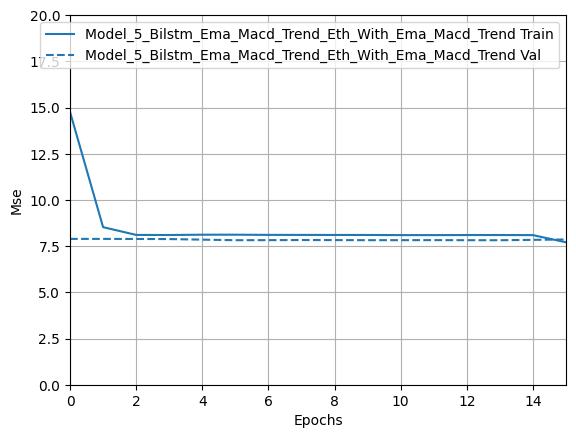

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric=metric_mse_name, smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0,20])

In [ ]:
# train_dataset = tf.data.Dataset.load(f'{dataset_folder}/train/next_3_day_up')
# test_dataset = tf.data.Dataset.load(f'{dataset_folder}/test/next_3_day_up')
# for x_train, y_train, date_train in train_dataset.take(2):
#     pass
# for x_test, y_test, date_test in test_dataset.take(2):
#     pass
# plt.imshow(x_train)
# y_train
# plt.imshow(x_test)
# y_test

In [ ]:
list_name_models

['model_5_biLSTM_ema_macd_trend_1_1', 'model_5_biLSTM_ema_macd_trend_1_1_1']

In [ ]:
dataset_folder

'../dataset/eth_with_ema_macd_trend'